In [1]:
import os
import pickle
import sys
import time

In [2]:
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns

In [3]:
from snmachine import snclassifier, gps, snfeatures, analysis
from snmachine.utils.plasticc_pipeline import create_folder_structure, get_directories, load_dataset
from snmachine.utils.plasticc_utils import plot_confusion_matrix, plot_roc_curve

In [4]:
%config Completer.use_jedi = False 

In [5]:
sns.set(font_scale=1.5, style="ticks")

In [6]:
folder_path = 'C:\\Users\\Alcatraz\\Desktop\\Supernova\\snmachine-main\\snmachine\\example_data'

In [7]:
data_file_name = 'example_test_dataset.pckl'

In [8]:
data_path = os.path.join(folder_path, data_file_name)
dataset = load_dataset(data_path)

Opening from binary pickle
Dataset loaded from pickle file as: <snmachine.sndata.PlasticcData object at 0x000001E5C3D92640>


In [9]:
max_gap_length = 50

In [10]:
dataset.remove_gaps(max_gap_length*2, verbose=True)
dataset.remove_gaps(max_gap_length*2, verbose=True)
dataset.remove_gaps(max_gap_length, verbose=True)
dataset.remove_gaps(max_gap_length, verbose=True)
dataset.remove_gaps(max_gap_length, verbose=True)

The longest event is 13926017 and its length is 1094.06 days.
The longest event is 13704710 and its length is 882.75 days.
The longest event is 10246631 and its length is 874.62 days.
The longest event is 6152283 and its length is 629.58 days.
The longest event is 1028147 and its length is 276.54 days.


In [11]:
print(f'The longest processed light curve has {dataset.get_max_length():.2f} days.')

The longest processed light curve has 276.54 days.


In [12]:
folder_path_to_save = folder_path
file_name = data_file_name[:-5]+'_gapless50.pckl'
file_name

'example_test_dataset_gapless50.pckl'

In [13]:
with open(os.path.join(folder_path_to_save, file_name), 'wb') as f:
    pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)

In [14]:
analysis_name = file_name[:-5]
analysis_name

'example_test_dataset_gapless50'

In [17]:
import os

def create_folder_structure(folder_path, analysis_name):
 
    for key, value in directories.items():
        os.makedirs(value, exist_ok=True)


folder_path = r'C:\Users\Alcatraz\Desktop\Supernova\snmachine-main\snmachine\example_data'
create_folder_structure(folder_path, analysis_name)


In [18]:
directories = get_directories(folder_path, analysis_name) 
path_saved_gps = directories['intermediate_files_directory']

In [19]:
t_min = 0
t_max = 278

gp_dim = 2
number_gp = 276
number_processes = 1

In [20]:
gps.compute_gps(dataset, number_gp=number_gp, t_min=t_min, t_max=t_max, 
                gp_dim=gp_dim, output_root=path_saved_gps, 
                number_processes=number_processes)

Performing Gaussian process regression.
Models fitted with the Gaussian Processes values.
Time taken for Gaussian process regression: 208.61s.


In [21]:
saved_test_wavelets_path = directories['intermediate_files_directory']
path_saved_eigendecomp = directories['analysis_directory']+'/../example_dataset_aug/wavelet_features'

In [22]:
path_saved_reduced_wavelets = directories['features_directory']
number_comps = 40

In [23]:
wf = snfeatures.WaveletFeatures(output_root=saved_test_wavelets_path)

test_reduced_wavelet_features = wf.compute_reduced_features(
    dataset, number_comps=number_comps, 
    path_saved_eigendecomp=path_saved_eigendecomp,
    **{'wavelet_name': 'sym2', 'number_decomp_levels': 2})

The wavelet used is sym2.
Each passband is decomposed in 2 levels.
Performing wavelet decomposition.
Time taken for wavelet decomposition: 19.95s.
Dimensionality reduced feature space with 40 components.


In [24]:
features = test_reduced_wavelet_features.copy()  

metadata = dataset.metadata
features['hostgal_photoz'] = metadata.hostgal_photoz.values.astype(float)
features['hostgal_photoz_err'] = metadata.hostgal_photoz_err.values.astype(float)

In [25]:
path_saved_features = directories['features_directory']

In [26]:
features.to_pickle(os.path.join(path_saved_features, 'features.pckl'))

In [27]:
analysis_name = 'example_test_dataset_gapless50'

In [28]:
directories = get_directories(folder_path, analysis_name) 
path_saved_features = directories['features_directory']

In [29]:
data_path = os.path.join(folder_path, analysis_name+'.pckl')
dataset = load_dataset(data_path)  

Opening from binary pickle
Dataset loaded from pickle file as: <snmachine.sndata.PlasticcData object at 0x000001E5CD2C7B20>


In [30]:
features = pd.read_pickle(os.path.join(path_saved_features, 'features.pckl')) 

In [31]:
path_saved_classifier = directories['analysis_directory']+'/../example_dataset_aug/classifications'
classifier_name = 'NN_classifier.pck'

In [32]:
with open(os.path.join(path_saved_classifier, classifier_name), 'rb') as input:
    classifier_instance = pickle.load(input)

In [33]:
classifier = classifier_instance.classifier

In [35]:
features.columns = features.columns.astype(str)
y_pred_test = classifier.predict(features)
y_probs_test = classifier.predict_proba(features)

In [36]:
data_labels = dataset.metadata.true_target  

In [38]:
# Access the unique classes predicted by the classifier
unique_classes = classifier.classes_
print("Unique classes:", unique_classes)


Unique classes: [42 62 90]


In [39]:
which_column = 2 

In [40]:
classifier.which_column = which_column
auc_test = snclassifier.auc_score(classifier=classifier, X_features=features, 
                                  y_true=data_labels, which_column=which_column)
logloss_test = snclassifier.logloss_score(classifier=classifier, X_features=features, 
                                          y_true=data_labels)
print('{:^10} {:^10} {:^10}'.format('', 'AUC', 'Logloss'))
print('{:^10} {:^10.3f} {:^10.3f}'.format('test', auc_test, logloss_test))

              AUC      Logloss  
   test      0.530      -1.102  


In [41]:
is_pred_right = y_pred_test == data_labels
np.sum(is_pred_right)

1454

Confusion matrix normalised by true class.


array([[0.1814059 , 0.60147392, 0.21712018],
       [0.22981366, 0.50621118, 0.26397516],
       [0.20555937, 0.46122169, 0.33321894]])

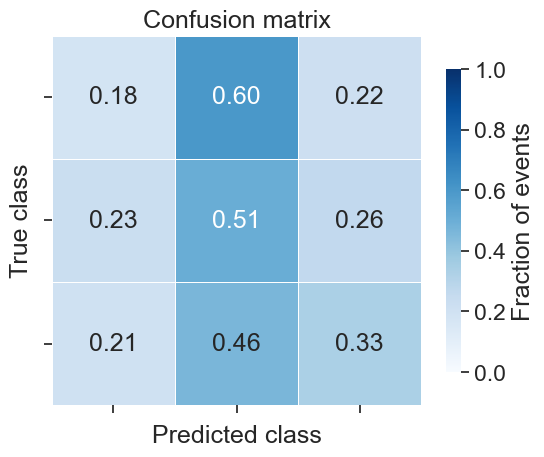

In [42]:
title = 'Confusion matrix'
analysis.plot_confusion_matrix(data_labels, y_pred_test, normalise='accuracy', title=title,
                               dict_label_to_real=analysis.dict_label_to_real_plasticc)

### ROC Curves<a name="roc"></a>

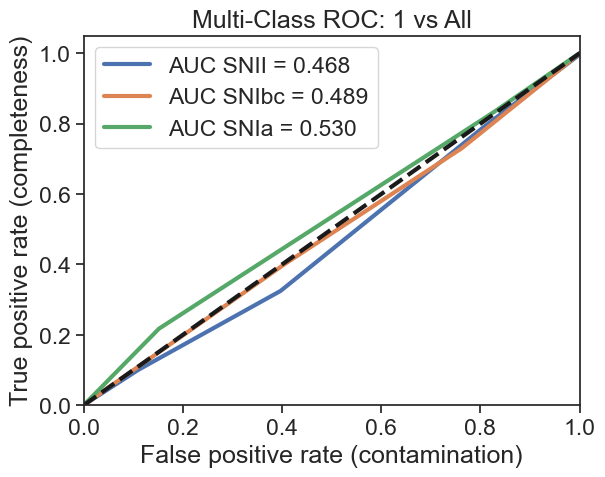

In [43]:
analysis.plot_classifier_roc_curve(data_labels, y_probs_test,
                                   dict_label_to_real=analysis.dict_label_to_real_plasticc)

In [44]:
is_true_snii = data_labels == 42
is_true_snibc = data_labels == 62
is_true_snia = data_labels == 90

is_pred_snii = y_pred_test == 42
is_pred_snibc = y_pred_test == 62
is_pred_snia = y_pred_test == 90


is_true_type_list = [is_true_snia, is_true_snibc, is_true_snii] 
is_pred_type_list = [is_pred_snia, is_pred_snibc, is_pred_snii]

In [45]:
lc_length = analysis.compute_lc_length(dataset)
quantity = lc_length

In [46]:
bins = np.linspace(0, 280, 6) 
use_mid_bins = True  
extra_subset = True  

In [47]:
sn_order = ['SN Ia', 'SN Ibc', 'SN II']
diverg_color = sns.color_palette("Set2", 3, desat=1)
sn_colors = [diverg_color[2], diverg_color[1], diverg_color[0]]

In [48]:
recall_s, boot_recall_ci, number_in_bin_s = analysis.compute_recall_values(
    quantity=quantity, bins=bins, is_pred_right=is_pred_right, 
    use_mid_bins=use_mid_bins, is_true_type_list=is_true_type_list)

Time taken to compute the recall values: 0.15s.


In [49]:
from importlib import reload
reload(analysis)

<module 'snmachine.analysis' from 'C:\\Users\\Alcatraz\\anaconda3\\envs\\tensorflow\\lib\\site-packages\\snmachine\\analysis.py'>

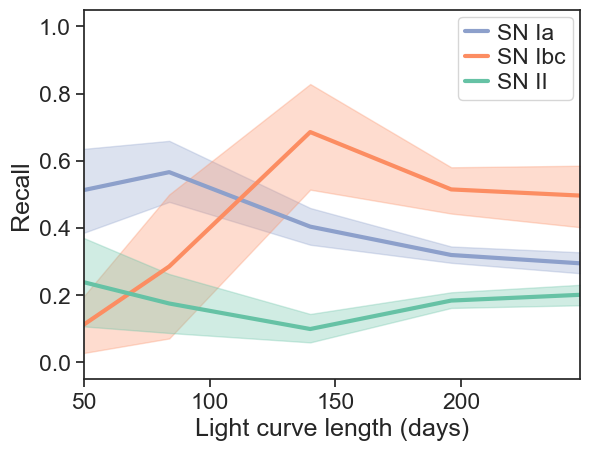

In [50]:
if use_mid_bins:
    mid_bins = (bins[:-1]+bins[1:])/2
    show_bins = mid_bins
else:
    show_bins = bins

x_label = 'Light curve length (days)'
x_min, x_max = 50, 247

analysis.plot_sne_has_something(
    something_s=recall_s, boot_has_something_ci=boot_recall_ci,
    bins=show_bins, is_true_type_list=is_true_type_list, 
    sn_order=sn_order, **{'colors': sn_colors})
plt.ylabel('Recall')
plt.xlabel(x_label)
plt.xlim(x_min, x_max) 
plt.ylim(-0.05, 1.05)
plt.legend(handletextpad=.4, borderaxespad=.3, handlelength=1,
           labelspacing=.2, borderpad=.3, columnspacing=.4)

In [51]:
precision_s, boot_precision_ci, number_in_bin_s = analysis.compute_precision_values(
    quantity=quantity, bins=bins, is_pred_right=is_pred_right, 
    use_mid_bins=use_mid_bins, is_pred_type_list=is_pred_type_list)

Time taken to compute the precision values: 0.15s.


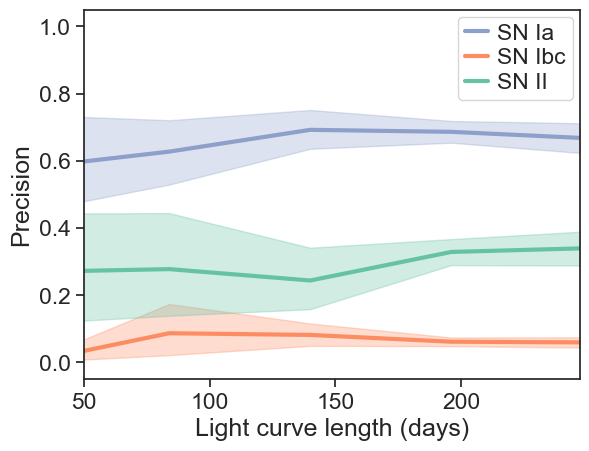

In [52]:
if use_mid_bins:
    mid_bins = (bins[:-1]+bins[1:])/2
    show_bins = mid_bins
else:
    show_bins = bins

x_label = 'Light curve length (days)'
x_min, x_max = 50, 247

analysis.plot_sne_has_something(
    something_s=precision_s, boot_has_something_ci=boot_precision_ci,
    bins=show_bins, is_true_type_list=is_true_type_list, 
    sn_order=sn_order, **{'colors': sn_colors})
plt.ylabel('Precision')
plt.xlabel(x_label)
plt.xlim(x_min, x_max) 
plt.ylim(-0.05, 1.05)
plt.legend(handletextpad=.4, borderaxespad=.3, handlelength=1,
           labelspacing=.2, borderpad=.3, columnspacing=.4)

In [53]:

!pip install umap-learn

In [54]:
import umap

In [55]:
um = umap.UMAP()
reduced_features = um.fit_transform(features)

Text(0, 0.5, 'Arbitrary unit')

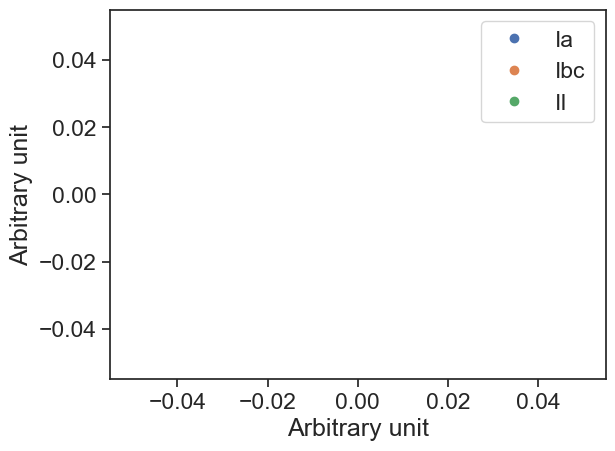

In [56]:
class_translations = {90:'Ia', 62:'Ibc', 42:'II'}
for key in class_translations.keys():
    msk = dataset.metadata.target == key
    plt.plot(reduced_features[msk,0], reduced_features[msk,1], marker='o', linestyle='none', label=class_translations[key])

plt.legend()
plt.xlabel('Arbitrary unit')
plt.ylabel('Arbitrary unit')